In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers
characterRecognition = tf.keras.models.load_model('model_char.h5')

def getSkewAngle(cvImage) -> float:
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(newImage, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(newImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)

    if(math.fabs(angle)>60):

        angle+=math.degrees(math.pi)/2
    
    return rotateImage(cvImage, -1.0 * angle)

def shadow_remove(img):
      rgb_planes = cv2.split(img)
      result_norm_planes = []
      for plane in rgb_planes:
          dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
          bg_img = cv2.medianBlur(dilated_img, 21)
          diff_img = 255 - cv2.absdiff(plane, bg_img)
          norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
          result_norm_planes.append(norm_img)
      shadowremov = cv2.merge(result_norm_planes)
      return shadowremov

def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
                  
    
    
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        k=intHeight/intWidth
        flag=False
#         print("\n")
#         print("x",intX)
#         print("y",intY)
#         print("w",intWidth)
#         print("h",intHeight)
#         print(lower_width,upper_width,lower_height,upper_height)
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > 0.9*lower_height and intHeight < upper_height and k<3  and k>0.8:
            flag=True
#             print("k",k)
            x_cntr_list.append(intX) 
            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)

            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    
        if (flag==False):
             
    
              if intWidth > 0.6*lower_height and intWidth<1.2*upper_height and intHeight>0.8*lower_width and intHeight<1.2*upper_width and k<3 and k>0.65:
#                     print("k",k)
                    x_cntr_list.append(intX) 
                    char_copy = np.zeros((44,24))
                    #extracting each character using the enclosing rectangle's coordinates.
                    char = img[intY:intY+intHeight, intX:intX+intWidth]
                    char = cv2.resize(char, (20, 40))

                    cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
#                     cv2.circle(ii,(intX+intWidth,intY+intHeight),2,(0,0,255),-1)
#                     cv2.circle(ii,(intWidth,intHeight),2,(0,0,255),-1)
                    plt.imshow(ii, cmap='gray')

        #             Make result formatted for classification: invert colors
                    char = cv2.subtract(255, char)

                    # Resize the image to 24x44 with black border
                    char_copy[2:42, 2:22] = char
                    char_copy[0:2, :] = 0
                    char_copy[:, 0:2] = 0
                    char_copy[42:44, :] = 0
                    char_copy[:, 22:24] = 0

                    img_res.append(char_copy)
            
    plt.show()
   
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))
#     print("before border white")
#     cv2_imshow(img_binary_lp)
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255
#     print("after border")
#     cv2_imshow(img_binary_lp)
    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,LP_WIDTH/2,LP_HEIGHT/10,2*LP_HEIGHT/3]
#     print("dimension" , dimensions)                   
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)
#     print("image chl gyi")

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

def fix_dimension(img): 
  new_img = np.zeros((28,28,1))
  for i in range(1):
    new_img[:,:,i] = img
  return new_img
  
def show_results(char):
    
    characters = {0:'0', 1:'1', 2 :'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A',
    11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K',
    21:'L', 22:'M', 23:'N', 24:'O', 25:'P', 26:'Q', 27:'R', 28:'S', 29:'T',
    30:'U', 31:'V', 32:'W', 33:'X', 34:'Y' , 35:'Z'}
    
    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        kernel = np.ones((3, 3), np.uint8)
        img_=cv2.erode(img_,kernel,iterations=1)
        element = cv2.getStructuringElement(shape = cv2.MORPH_RECT, ksize =(5, 5))
    
        img_=cv2.morphologyEx(src = img_, op = cv2.MORPH_CLOSE,kernel = element)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,1) #preparing image for the model
        
        y_ = characterRecognition.predict_classes(img)[0]
        character = characters[y_] 
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

def PlateRecognition(img):
    char = segment_characters(img)
    if(len(char)<7):
#         print("shadow")
        img=shadow_remove(img)
        char = segment_characters(img)
    
    for i in range(len(char)):
        plt.subplot(1, len(char), i+1)
        plt.imshow(char[i], cmap='gray')
        plt.axis('off')    
    print(show_results(char))

    plt.figure(figsize=(10,6))
    for i,ch in enumerate(char):
        img = cv2.resize(ch, (28,28))
        plt.subplot(3,4,i+1)
        plt.imshow(img,cmap='gray')
        plt.title(f'predicted: {show_results(char)[i]}')
        plt.axis('off')
    plt.show()



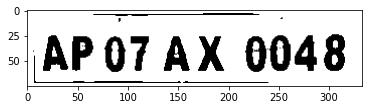

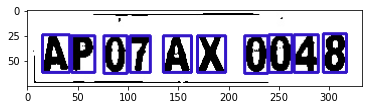

APO7AX0048


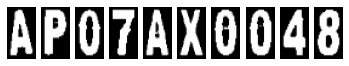

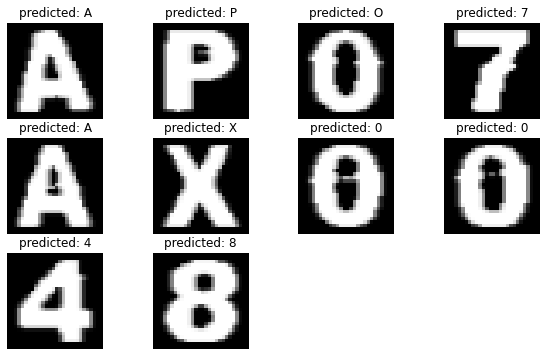

In [3]:
if __name__ == '__main__':
    img = cv2.imread('test.jpg')
#     img=cv2.imread('F:/AI-based-indian-license-plate-detection/51 (20).png')
    PlateRecognition(img)
#     path= r'D:/downloads/MosaicPS2/indian_plates'
#     for filename in os.listdir(path):
#         img=cv2.imread(os.path.join(pat, filename)) 
#  HH7L0T6998       